# Introduction to DisCoPy

In [2]:
from discopy.symmetric import Ty

print(Ty('sentence', 'qubit'))

sentence @ qubit


In [3]:
egg, white, yolk = Ty(*['egg', 'white', 'yolk'])

assert egg @ (white @ yolk) == (egg @ white) @ yolk #associativity
assert egg @ Ty() == egg == Ty() @ egg #unitality

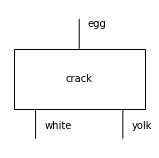

In [4]:
from discopy.symmetric import Box

crack = Box(name = 'crack', dom = egg, cod = white @ yolk)
crack.draw(figsize = (2,2))

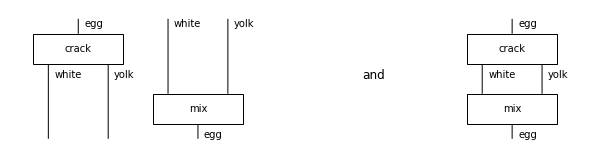

In [5]:
mix = Box('mix', white @ yolk, egg)

crack_tensor_mix = crack @ mix
crack_then_mix = crack >> mix

from discopy.drawing import Equation

Equation(crack_tensor_mix, crack_then_mix, symbol = 'and').draw(space = 2, figsize=(8,2))

In [6]:
from discopy.symmetric import Id

assert crack >> Id(white @ yolk) == crack == Id(egg) >> crack
assert crack @ Id() == crack == Id() @ crack

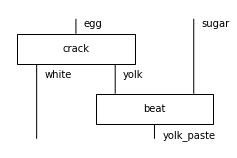

In [7]:
sugar, yolk_paste = Ty('sugar'), Ty('yolk_paste')
beat = Box('beat', yolk @ sugar, yolk_paste)

crack_then_beat = crack @ sugar >> white @ beat
crack_then_beat.draw(figsize = (3,2))

## Functor

While `Diagram` is the core data structure of Discopy, `Functor` is th emain algorithm. It is initialised by two mappings:
    <ul>
        <li> `ob`: maps objets to types. </li>
        <li> `ar`: map boxes to diagrams </li>
    </ul>

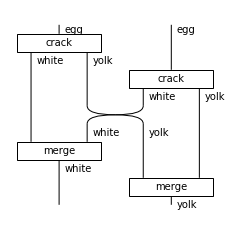

In [10]:
from discopy.symmetric import Swap

merge = lambda x: Box('merge', x @ x, x)

crack_two_eggs = crack @ crack\
    >> white @ Swap(yolk, white) @ yolk\
    >> merge(white) @ merge(yolk)
    
crack_two_eggs.draw(figsize=(3,3)) 

In [11]:
from discopy.symmetric import Diagram

assert crack_two_eggs == Diagram.decode(
    dom=egg @ egg, boxes_and_offsets=[
        (crack,             0),
        (crack,             2),
        (Swap(yolk, white), 1),
        (merge(white),      0),
        (merge(yolk),       1)])

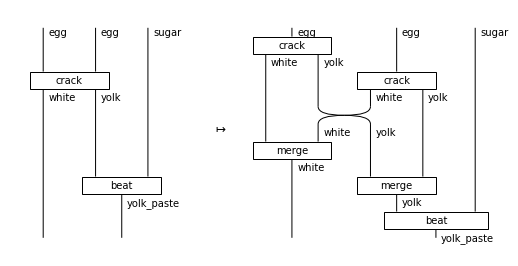

In [12]:
from discopy.symmetric import Functor

crack2 = Box("crack", egg @ egg, white @ yolk)

open_crack2 = Functor(
    ob=lambda x: x,
    ar={crack2: crack_two_eggs, beat: beat})

crack2_then_beat = crack2 @ Id(sugar) >> Id(white) @ beat

Equation(crack2_then_beat, open_crack2(crack2_then_beat),
         symbol='$\\mapsto$').draw(figsize=(7, 3.5))

**Let's cook a Salad**

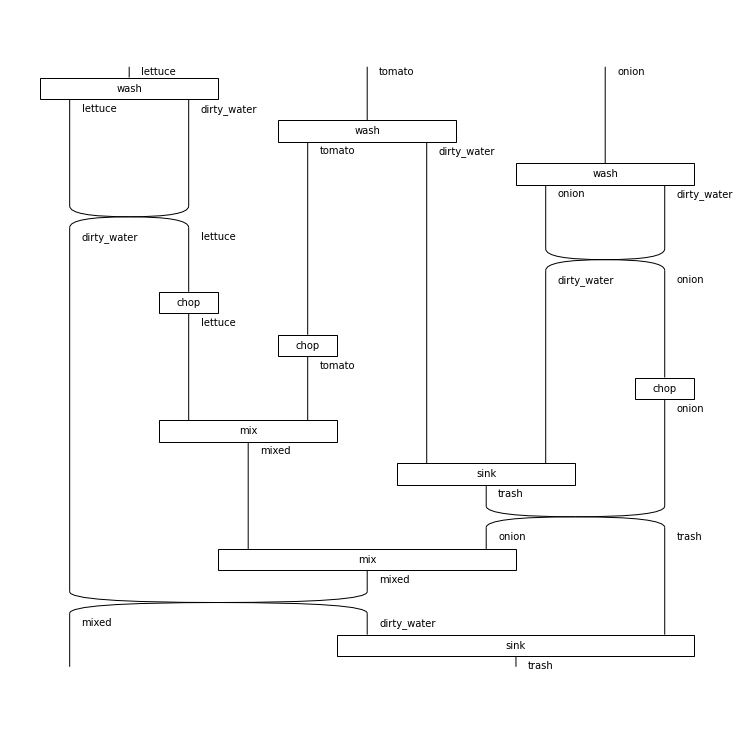

In [13]:

# we define elements of diagram
dirty_water, trash,  lettuce, tomato, onion, mixed = Ty(*['dirty_water', 'trash', 'lettuce', 'tomato', 'onion', 'mixed'])

# now define verbs to use in recipe
wash = lambda x: Box('wash', x , x @ dirty_water)
chop = lambda x: Box('chop', x , x)
mix = lambda x, y: Box('mix', x @ y, mixed)
sink = lambda x,y: Box('sink', x @ y , trash)

wash_all = wash(lettuce) @ wash(tomato) @ wash(onion)

# lets cook
salad = wash_all\
    >> Swap(lettuce, dirty_water) @ tomato @ dirty_water @ Swap(onion, dirty_water)\
    >> dirty_water @ chop(lettuce) @ chop(tomato) @ dirty_water @ dirty_water @ chop(onion) \
    >> dirty_water @ mix(lettuce, tomato) @ sink(dirty_water, dirty_water) @ onion \
    >> dirty_water @ mixed @ Swap(trash, onion)\
    >> dirty_water @ mix(mixed, onion) @ trash\
    >> Swap(dirty_water, mixed) @ trash\
    >> mixed @ sink(dirty_water, trash)
        
    

salad.draw(figsize = (10, 10))

## Tensor as boxes

In [14]:
from discopy.tensor import Dim, Tensor

matrix = Tensor([0,1,1,0], Dim(2), Dim(2))

matrix.array

array([[0, 1],
       [1, 0]])

In [15]:
cup, cap = Tensor.cups(Dim(2), Dim(2)), Tensor.caps(Dim(2), Dim(2))

print("cup == {}".format(cup))
print("cap == {}".format(cap))

cup == Tensor([1, 0, 0, 1], dom=Dim(2, 2), cod=Dim(1))
cap == Tensor([1, 0, 0, 1], dom=Dim(1), cod=Dim(2, 2))


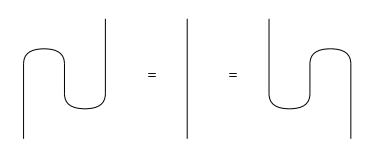

In [16]:
from discopy.tensor import Cup, Cap, Id

left_snake = Cap(Dim(2), Dim(2)) @ Id(Dim(2)) >> Id(Dim(2)) @ Cup(Dim(2), Dim(2))
right_snake = Id(Dim(2)) @ Cap(Dim(2), Dim(2)) >> Cup(Dim(2), Dim(2)) @ Id(Dim(2))

Equation(left_snake, Id(Dim(2)), right_snake).draw(figsize=(5, 2), draw_type_labels=False)

Two diagrams that are drawn differently cannot be equal Python objects: they have different lists of boxes and offsets. What we can say however, is that the diagrams are interpreted as the same `Tensor` box. This interpretation can be computed using a `tensor.Functor`, defined by two mappings: `ob` from type to dimension (e.g. qubit to Dim(2)) and `ar` from box to array (e.g. X to [0, 1, 1, 0]). For now let’s take these two mappings to be identity functions.

In [80]:
from discopy import tensor

_eval = tensor.Functor(
    ob=lambda x: x,
    ar=lambda f: f)

assert _eval(left_snake) == _eval(Id(Dim(2))) == _eval(right_snake)

A `tensor.Diagram`, also called a *tensor network*, is a subclass of `Diagram` equipped with such an `eval` method. A `tensor.Box`, also called a *node* in a tensor network, is a subclass of `Box` equipped with an attribute `array`. The evaluation a tensor diagram, i.e. the `tensor.Functor` that maps each box to its array, is also called *tensor contraction*.

The distinction between a `tensor.Diagram` and its interpretation as a `Tensor` is crucial. Indeed, two diagrams that evaluate to the same tensor may take very different times to compute. For example, cups and caps allows us to define the transpose of a matrix as a diagram:

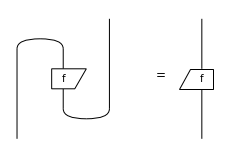

Tensor([1, 3, 2, 4], dom=Dim(2), cod=Dim(2))


In [17]:
from discopy import tensor

f = tensor.Box("f", Dim(2), Dim(2), [1, 2, 3, 4])

Equation(f.transpose(), f.r).draw(figsize=(3, 2), draw_type_labels=False)

print(f.r.eval())

In [18]:
%timeit f.transpose().transpose().eval()

13.4 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit f.eval()

61.3 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Quantum Circuirs

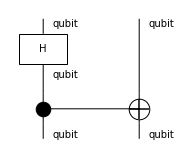

In [20]:
from discopy.quantum import qubit, H, Id, CX, SWAP, QuantumGate

circuit = H @ qubit >> CX

circuit.draw(figsize=(2,2), draw_type_labels = True, margins = (0.1, 0.1))

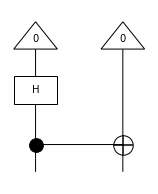

In [21]:
from discopy.quantum import Ket

(Ket(0, 0) >> circuit).draw(figsize=(2, 2.5))

In [22]:
# it gives 1/sqrt(2)[1,0,0,1]
(Ket(0, 0) >> circuit).eval()

Tensor[complex]([0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j], dom=Dim(1), cod=Dim(2, 2))

amplitude: (0.7071067811865476+0j)


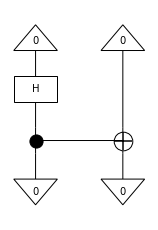

probability: 0.5000000000000001


In [23]:
from discopy.quantum import Bra

experiment = Ket(0, 0) >> circuit >> Bra(0, 0)
amplitude = experiment.eval().array

print(f"amplitude: {amplitude}")
experiment.draw(figsize=(2, 3))

print(f"probability: {abs(amplitude) ** 2}")

In [24]:
from discopy.quantum import Measure, Discard

print(Discard().eval())
print(Measure().eval())

Channel([1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j], dom=Q(Dim(2)), cod=CQ())
Channel([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j], dom=Q(Dim(2)), cod=Q(Dim(2)))


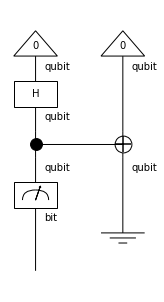

Channel([0.5+0.j, 0.5+0.j], dom=CQ(), cod=Q(Dim(2)))

In [25]:
(Ket(0, 0) >> circuit >> Measure() @ Discard()).draw(figsize=(2, 4))
(Ket(0, 0) >> circuit >> Measure() @ Discard()).eval()

**Let's Draw the GHZ state $\frac{1}{\sqrt{2}}[|000\rangle + |111\rangle]$**

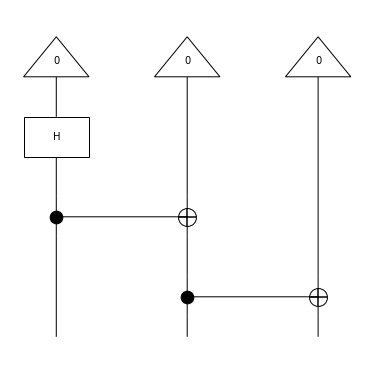

Tensor[complex]([0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.    +0.j,
 0.    +0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j], dom=Dim(1), cod=Dim(2, 2, 2))

In [26]:
# As we can see in eval(), the 8 component tensor gives ghz's state.
ghz = H @ qubit @ qubit >> CX @ qubit >> qubit @ CX

ghz_complete = (Ket(0,0,0) >> ghz)

ghz_complete.draw(figsize = (5,5))
ghz_complete.eval()

## DisCoCat

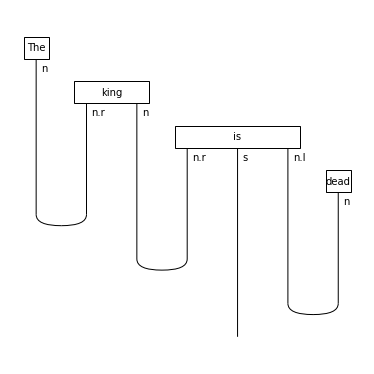

In [82]:
The = Word('The', n )
king = Word('king', n.r @ n)
iss = Word('is', n.r @ s @ n.l)
dead = Word('dead', n)

grammar = Cup(n, n.r) @ Cup(n, n.r) @ s @ Cup(n.l, n)

sentence = The @ king @ iss @ dead >> grammar
sentence.draw(figsize = (5,5))

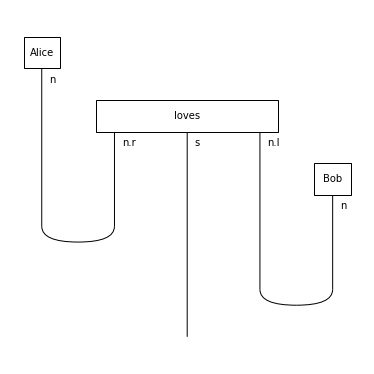

In [83]:
from discopy.grammar.pregroup import Ty, Id, Word, Cup, Diagram

n, s = Ty('n'), Ty('s')

Alice = Word("Alice", n)
loves = Word("loves", n.r @ s @ n.l)
Bob = Word("Bob", n)

grammar = Cup(n, n.r) @ s @ Cup(n.l, n)

sentence = Alice @ loves @ Bob >> grammar
sentence.draw(figsize=(5, 5))

Now the main idea behind `DisCoCat` (categorical compositional distributional) models is to interpret each word as a vector and the grammatical structure as a linear map. Composing the tensor of word vectors with the linear map for grammar yields the meaning of the sentence. Another way to say this is in the language of tensor networks: computing the meaning of a sentence corresponds to tensor contraction along the grammatical structure.

Yet another way to say the same thing is in the language of category theory: computing the meaning of a sentence corresponds to the evaluation of a (strong monoidal) functor from a pregroup grammar to the category of linear maps. 

Let's build a simple toy model where:

<ul>
    <li> we map `n` as 2, i.e we encode a `noun` as a 2d vector.</li>
    <li> we map `s` to 1, i.e we encode a sentence as a scalar.</li>
    <li> we map `Alice` and `Bob` to [0,1] and [1,0], i.e we encode them as a basis vector.</li>
    <li> we map ´loves´ to the matrix [[0,1],[1,0]], i.e `Alice loves Bob` and `Bob loves Alice`.</li>

In [84]:
from discopy.cat import Category

F = tensor.Functor(
    ob={n: 2, s: 1},
    ar={Alice: [0, 1], loves: [0, 1, 1, 0], Bob: [1, 0]},
    dom=Category(Ty, Diagram))

print(F(Alice @ loves @ Bob))
print(F(grammar))

assert F(Alice @ loves @ Bob >> grammar).array == 1

Tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], dom=Dim(1), cod=Dim(2, 2, 2, 2))
Tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1], dom=Dim(2, 2, 2, 2), cod=Dim(1))


Let's define some more words:
<ul>
    <li> we map `man` to [1,0], i.e, Bob is the only man in our model. </li>
    <li> we map the adjetive rich  of type `n @ n.l` to the proyector [[1,0],[0,0]] i.e, only Bob is rich.</li>
</ul>

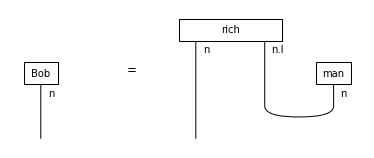

In [85]:
rich, man = Word("rich", n @ n.l), Word("man", n)

F.ar[rich], F.ar[man] = [1, 0, 0, 0], [1, 0]

rich_man = rich @ man >> Id(n) @ Cup(n.l, n)

assert F(Bob) >> F(rich_man).dagger()  # i.e. Bob is a rich man.

Equation(Bob, rich_man).draw(figsize=(5, 2))

If we draw the diagram of a Who? question, the inner product with a noun phrase measures how well it answers the question.

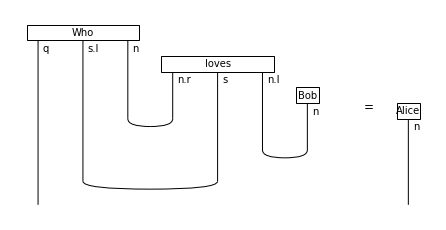

In [86]:
q = Ty('q')

Who = Word("Who", q @ s.l @ n)

F.ob[q], F.ar[Who] = 2, [1, 0, 0, 1]

question = Who @ loves @ Bob\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s)

answer = Alice

assert F(question) == F(answer)

Equation(question, answer).draw(figsize=(6, 3))

## Puting it all together 

Let’s recap what we’ve seen so far:

Diagrams can represent any cooking recipe, functors translate recipes.

Diagrams can represent any tensor network, tensor functors contract the network.

Diagrams can represent any quantum circuit, tensor functors simulate the circuit.

Diagrams can represent any grammatical sentence, tensor functors compute the meaning.

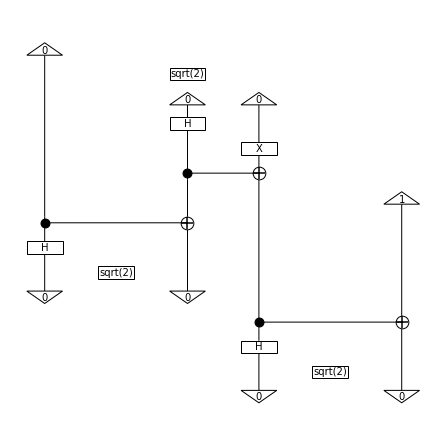

AttributeError: 'Tensor' object has no attribute 'cast'

In [87]:
from discopy.quantum import circuit, qubit, sqrt, X

F_ = circuit.Functor(
    ob={s: qubit ** 0, n: qubit ** 1},
    ar={Alice: Ket(0),
        loves: sqrt(2) @ Ket(0, 0) >> H @ X >> CX,
        Bob: Ket(1)})
F_.dom = Category(Ty, Diagram)

F_(sentence).draw(figsize=(6, 6))

assert F_(sentence).eval().is_close(F(sentence).cast(complex))

Of course this is a toy example: we’ve picked by hand what the circuits for Alice, loves and Bob should be so that they fit our interpretation. In order to apply our QNLP model to the real world, we need to learn from data what the circuits should be. In practice, we pick a parametrised circuit for each type of word, an ansatz, we then tune the parameters so that they reproduce our data.